1. Introduction
2. Load and check data
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
3. Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
4. Filling missing values
    - 4.1 Age
5. Feature engineering
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
6. Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        - 6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

## Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## Load and check data

### Load data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

### Outlier detection

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 *  IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

In [4]:
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### joining train and test set

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis

### Numerical values

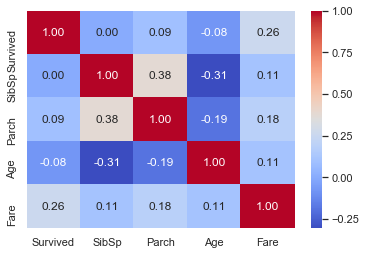

In [15]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

SibSp

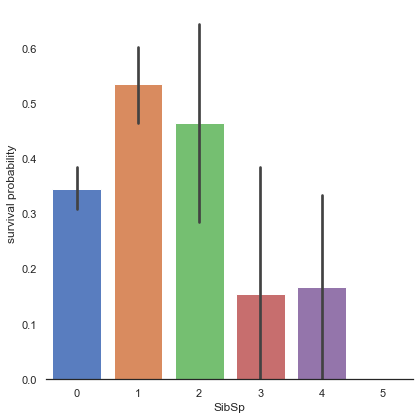

In [17]:
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

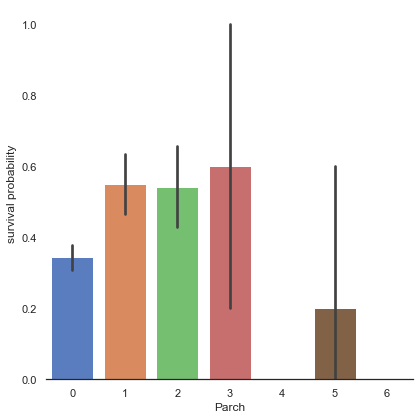

In [18]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

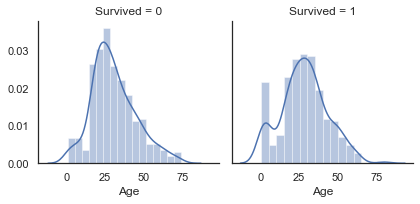

In [19]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

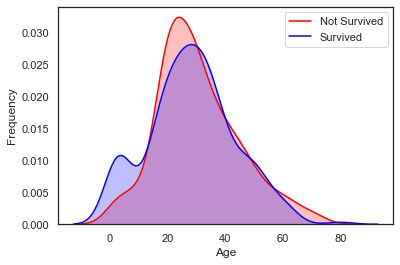

In [20]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color='Blue', shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", 'Survived'])

In [21]:
dataset['Fare'].isnull().sum()

1

In [24]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

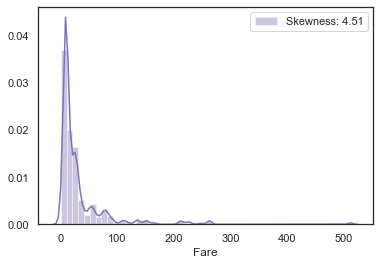

In [25]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [26]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

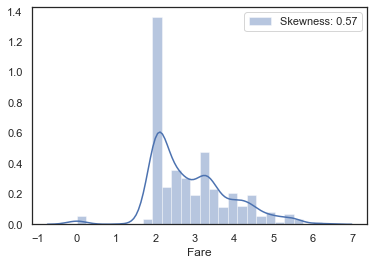

In [27]:
g = sns.distplot(dataset['Fare'], color='b', label="Skewness: %.2f"%(dataset['Fare'].skew()))
g = g.legend(loc='best')

### Categorical values

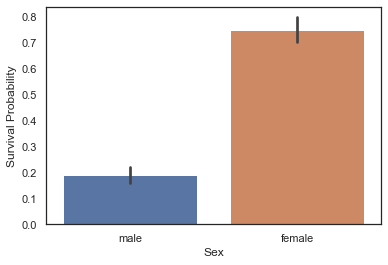

In [28]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [29]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


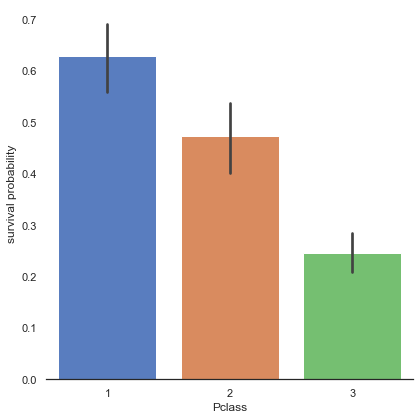

In [30]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

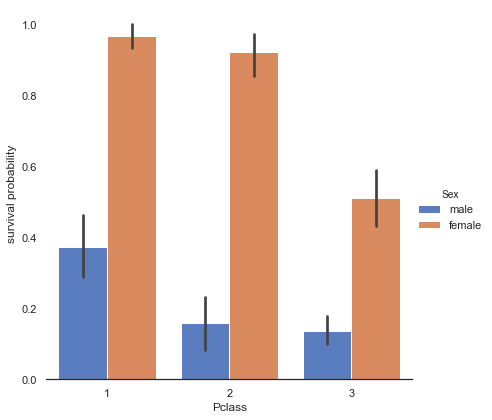

In [31]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

In [32]:
dataset['Embarked'].isnull().sum()

2

In [33]:
dataset['Embarked'] = dataset['Embarked'].fillna("S")

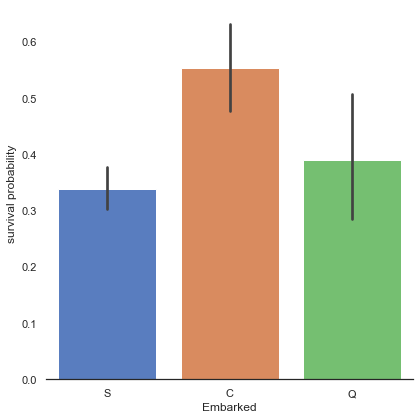

In [34]:
g = sns.catplot(x='Embarked', y='Survived', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

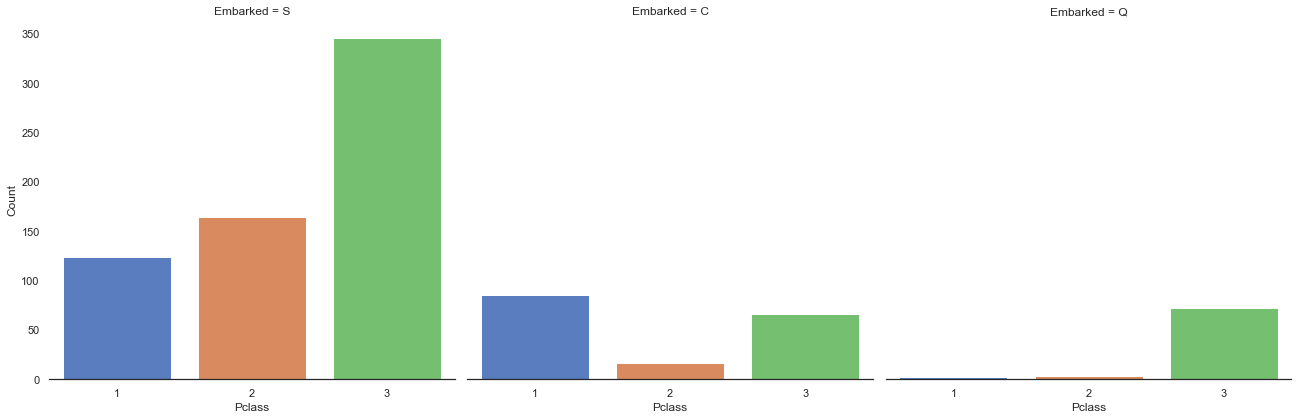

In [35]:
g = sns.catplot('Pclass', col='Embarked', data=train, height=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

## Filling missing Values

### Age

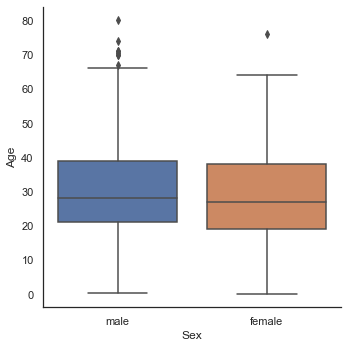

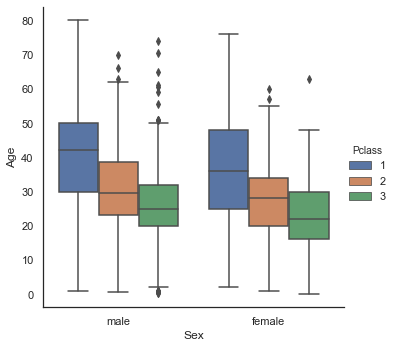

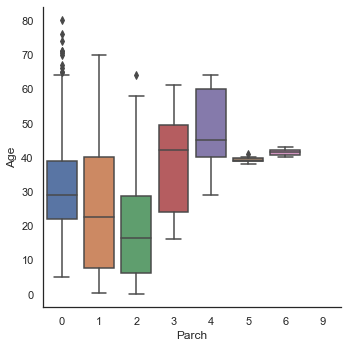

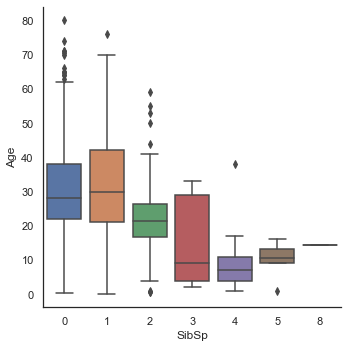

In [36]:
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

In [37]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

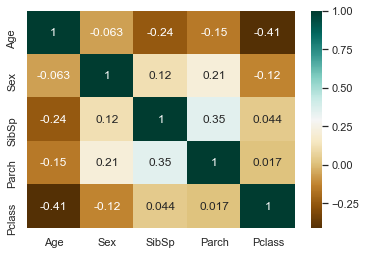

In [38]:
g = sns.heatmap(dataset[["Age", 'Sex', 'SibSp', "Parch", 'Pclass']].corr(), cmap='BrBG', annot=True)

In [39]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


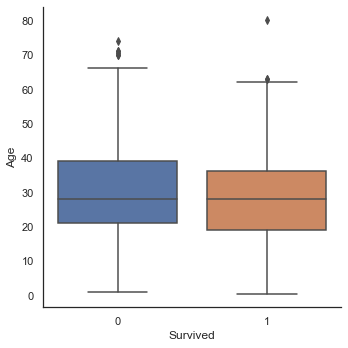

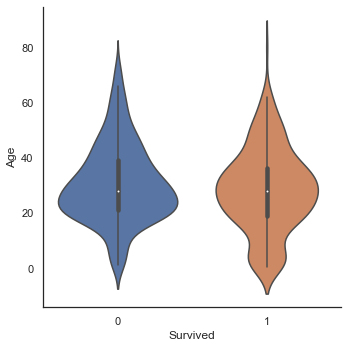

In [41]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

## Feature engineering

### Name/Title

In [42]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [43]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

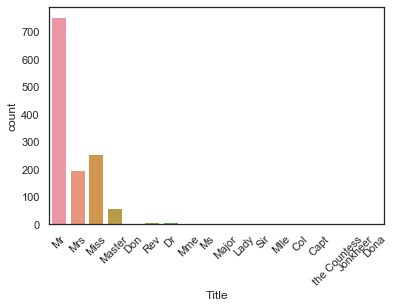

In [44]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [45]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

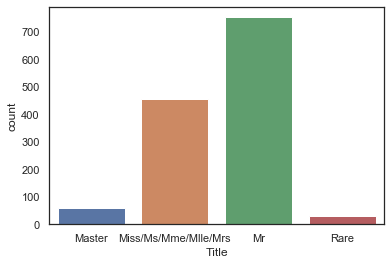

In [46]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', "Mr", "Rare"])

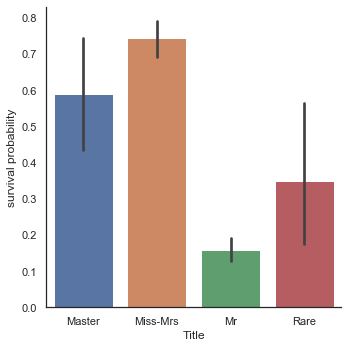

In [47]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [48]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

### Familiy size

In [49]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


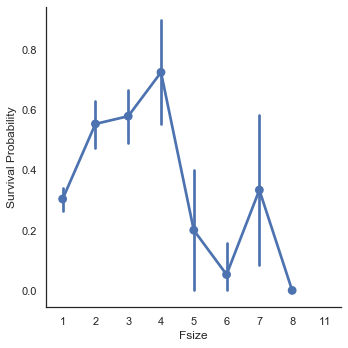

In [52]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

In [53]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >=5 else 0)

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


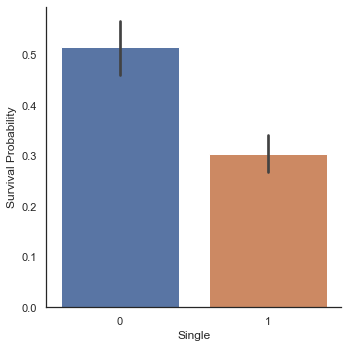

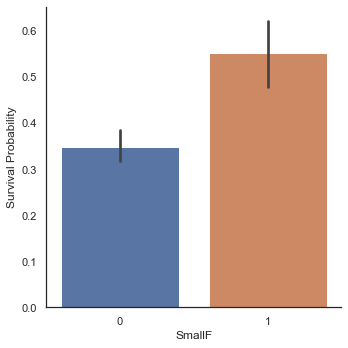

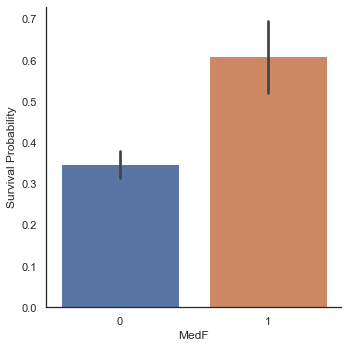

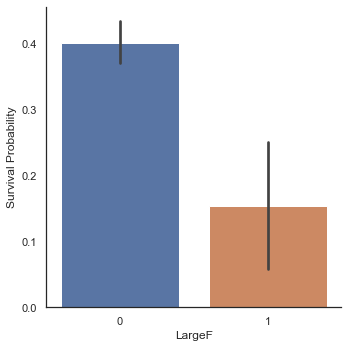

In [54]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

In [55]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [56]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


### Cabin

In [57]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [58]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [59]:
dataset['Cabin'].isnull().sum()

1007

In [60]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [61]:
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

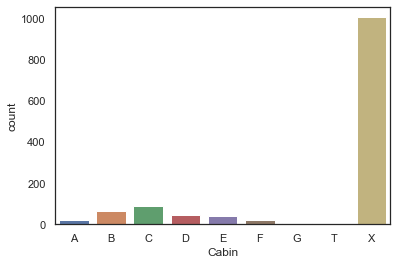

In [62]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


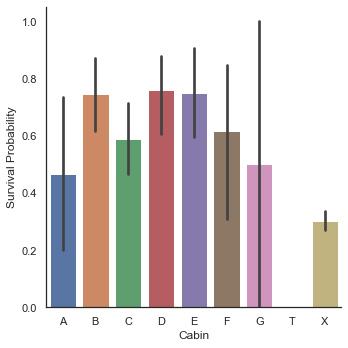

In [63]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

In [64]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### Ticket

In [65]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [66]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append("X")

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [67]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [68]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')